In [2]:
import pandas as pd
import numpy as np

In [3]:
%pwd

'/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/src/analysis/round4'

In [4]:
%cd ../../../data/round4/preprocessed

/Users/IvanTang/quant/IMC_Prosperity3_GraniteFlow/data/round4/preprocessed


In [5]:
%ls

mid_price_day0.csv  mid_price_day1.csv  mid_price_day2.csv  mid_price_day3.csv


In [7]:
df_mid_0 = pd.read_csv('mid_price_day0.csv')
df_mid_1 = pd.read_csv('mid_price_day1.csv')
df_mid_2 = pd.read_csv('mid_price_day2.csv')
df_mid_3 = pd.read_csv('mid_price_day3.csv')

In [8]:
df_mid_0['T'] = (7 - df_mid_0['timestamp'] * 0.0001 / 100  ) / 365
df_mid_1['T'] = (6 - df_mid_1['timestamp'] * 0.0001 / 100  ) / 365
df_mid_2['T'] = (5 - df_mid_2['timestamp'] * 0.0001 / 100  ) / 365
df_mid_3['T'] = (4 - df_mid_3['timestamp'] * 0.0001 / 100  ) / 365

In [9]:
from scipy.stats import norm
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import numpy as np

def bs_call_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility(S, K, T, r, market_price):
    loss_fn = lambda sigma: (bs_call_price(S, K, T, r, sigma) - market_price)**2
    result = minimize_scalar(loss_fn, bounds=(1e-4, 3.0), method='bounded')
    return result.x

def calculate_iv(df):
    df = df.copy()
    strick_prices = [9500, 9750, 10000, 10250, 10500]
    for strick_price in strick_prices:
        df['iv_' + str(strick_price)] = df.apply(lambda row: implied_volatility(
            row['VOLCANIC_ROCK'], strick_price, row['T'], 0, row['VOLCANIC_ROCK_VOUCHER_' + str(strick_price)]), axis=1)
    return df

def calculate_moneyness(df):
    df = df.copy()
    strike_prices = [9500, 9750, 10000, 10250, 10500]
    for strike in strike_prices:
        df[f'm_{strike}'] = df.apply(lambda row: np.log(strike / row['VOLCANIC_ROCK']) / np.sqrt(row['T']), axis=1)
    return df

def fit_iv_curve(df):
    """返回每个时间点 t 的 beta 系数（β₀, β₁, β₂），强制 β₂ ≥ 0"""
    betas = []

    for idx, row in df.iterrows():
        m_values = []
        iv_values = []

        for strike in [9500, 9750, 10000, 10250, 10500]:
            m = row[f'm_{strike}']
            iv = row[f'iv_{strike}']
            if 0 < iv < 2:  # 排除极端值
                m_values.append(m)
                iv_values.append(iv)

        if len(m_values) >= 3:
            # 第一次完整拟合
            X_full = np.column_stack([np.ones(len(m_values)), 
                                    m_values, 
                                    np.square(m_values)])
            beta = np.linalg.lstsq(X_full, iv_values, rcond=None)[0]
            
            # 如果 β₂ < 0，则回退到受限拟合
            if beta[2] < 0:
                X_restrict = np.column_stack([np.ones(len(m_values)),
                                            np.square(m_values)])
                beta_restrict = np.linalg.lstsq(X_restrict, iv_values, rcond=None)[0]
                
                # 强制 β₂ ≥ 1e-6 (接近零的小正数)
                beta_2 = max(beta_restrict[1], 1e-6)
                beta = [beta_restrict[0], 0.0, beta_2]  # β₁ 设为 0
                
        else:
            beta = [np.nan, np.nan, np.nan]

        betas.append(beta)

    df[['beta_0', 'beta_1', 'beta_2']] = pd.DataFrame(betas, index=df.index)
    return df


def add_fitted_ivs(df, strike_prices=[9500, 9750, 10000, 10250, 10500]):
    df = df.copy()
    for strike in strike_prices:
        m_col = f'm_{strike}'
        fitted_col = f'fitted_iv_{strike}'
        df[fitted_col] = df.apply(
            lambda row: row['beta_0'] + row['beta_1'] * row[m_col] + row['beta_2'] * row[m_col]**2
            if not np.isnan(row['beta_0']) and not np.isnan(row[m_col]) else np.nan,
            axis=1
        )
    return df

def calculate_base_iv(df):
    df['base_iv'] = df['beta_0']  # 因为在 m = 0 时，β₁·m + β₂·m² 都为0
    return df

In [10]:
def preprocess(df):
    df = df.copy()
    df = calculate_iv(df)
    df = calculate_moneyness(df)
    df = fit_iv_curve(df)
    df = add_fitted_ivs(df)
    df = calculate_base_iv(df)
    return df

In [11]:
df_mid_0 = preprocess(df_mid_0)
df_mid_1 = preprocess(df_mid_1)
df_mid_2 = preprocess(df_mid_2)
df_mid_3 = preprocess(df_mid_3)
df_mid_0.to_csv('day0.csv', index=False)
df_mid_1.to_csv('day1.csv', index=False)
df_mid_2.to_csv('day2.csv', index=False)
df_mid_3.to_csv('day3.csv', index=False)

In [13]:
df_mid_1

,timestamp,day,VOLCANIC_ROCK,VOLCANIC_ROCK_VOUCHER_9500,VOLCANIC_ROCK_VOUCHER_9750,VOLCANIC_ROCK_VOUCHER_10000,VOLCANIC_ROCK_VOUCHER_10250,VOLCANIC_ROCK_VOUCHER_10500,T,iv_9500,...,m_10500,beta_0,beta_1,beta_2,fitted_iv_9500,fitted_iv_9750,fitted_iv_10000,fitted_iv_10250,fitted_iv_10500,base_iv
0,0,1,10516.0,1016.0,766.5,517.5,279.5,95.5,0.016438,0.081794,...,-0.011876,0.190137,0.000000,0.000001,0.190138,0.190137,0.190137,0.190137,0.190137,0.190137
1,100,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300232,...,-0.011134,0.164007,0.048355,0.276766,0.299217,0.231583,0.187527,0.165350,0.163503,0.164007
2,200,1,10515.0,1015.5,765.5,516.5,278.5,94.5,0.016438,0.300234,...,-0.011134,0.164008,0.048355,0.276764,0.299220,0.231585,0.187528,0.165351,0.163504,0.164008
3,300,1,10517.0,1017.5,767.5,519.5,280.5,95.5,0.016438,0.300734,...,-0.012618,0.162297,0.000512,0.216707,0.298252,0.237595,0.195595,0.170913,0.162325,0.162297
4,400,1,10519.5,1019.5,770.5,521.5,282.5,97.5,0.016437,0.081980,...,-0.014472,0.194633,0.000000,0.000001,0.194634,0.194633,0.194633,0.194633,0.194633,0.194633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,1,10224.5,725.5,476.5,237.5,66.5,9.5,0.013700,0.268090,...,0.227161,0.160572,0.003742,0.275953,0.267022,0.204537,0.169791,0.160776,0.175662,0.160572
9996,999600,1,10225.5,725.5,477.5,237.5,66.5,9.5,0.013700,0.070751,...,0.226327,0.185440,0.000000,0.000001,0.185440,0.185440,0.185440,0.185440,0.185440,0.185440
9997,999700,1,10222.0,722.5,472.5,234.5,64.5,9.5,0.013699,0.246240,...,0.229254,0.154998,0.043547,0.284831,0.239304,0.183876,0.156853,0.156171,0.179951,0.154998
9998,999800,1,10223.5,723.5,474.5,237.5,65.5,9.5,0.013699,0.070611,...,0.228003,0.184792,0.000000,0.000001,0.184793,0.184793,0.184792,0.184792,0.184792,0.184792


In [14]:
df0 = pd.read_csv('day0.csv')
df1 = pd.read_csv('day1.csv')
df1['timestamp'] = df1['timestamp'] + 1000000
df2 = pd.read_csv('day2.csv')
df2['timestamp'] = df2['timestamp'] + 2000000
df3 = pd.read_csv('day3.csv')
df3['timestamp'] = df3['timestamp'] + 3000000
df = pd.concat([df0, df1, df2, df3], ignore_index=True)


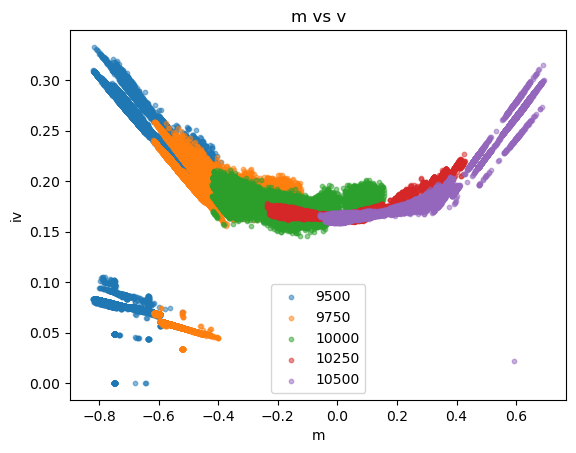

In [16]:
#画出m, iv散点图
import pandas as pd
import matplotlib.pyplot as plt

plt.scatter(df['m_9500'], df['iv_9500'], s=10, alpha=0.5, label = '9500')
plt.scatter(df['m_9750'], df['iv_9750'], s=10, alpha=0.5, label = '9750')
plt.scatter(df['m_10000'], df['iv_10000'], s=10, alpha=0.5, label = '10000')
plt.scatter(df['m_10250'], df['iv_10250'], s=10, alpha=0.5, label = '10250')
plt.scatter(df['m_10500'], df['iv_10500'], s=10, alpha=0.5, label = '10500')
plt.title('m vs v')
plt.xlabel('m')
plt.ylabel('iv')
plt.legend()
plt.show()

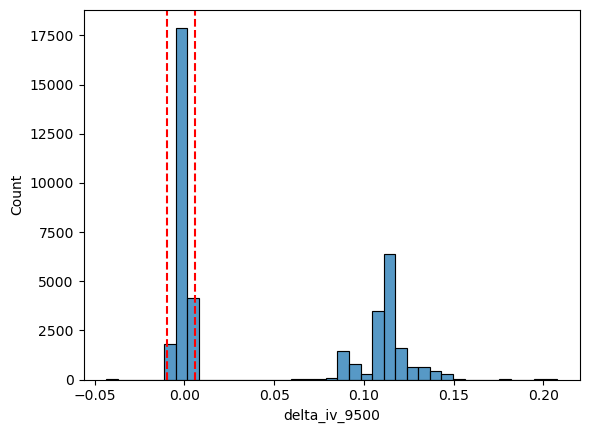

In [18]:
df['delta_iv_9500'] = df['fitted_iv_9500'] - df['iv_9500']
import seaborn as sns
sns.histplot(df['delta_iv_9500'])
plt.axvline(x = 0.006, color='r', linestyle='--')
plt.axvline(x = -0.01, color='r', linestyle='--')

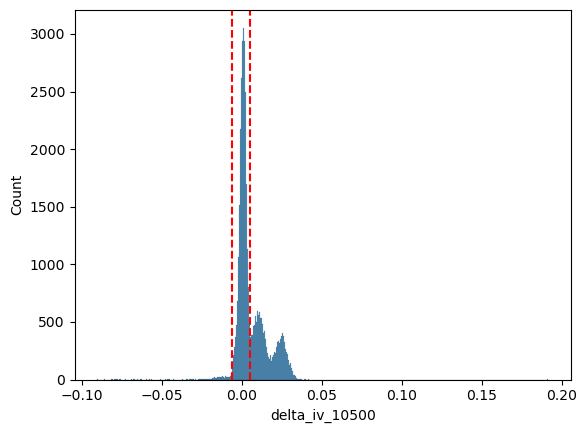

In [17]:
df['delta_iv_10500'] = df['fitted_iv_10500'] - df['iv_10500']
import seaborn as sns
sns.histplot(df['delta_iv_10500'])
plt.axvline(x = 0.005, color='r', linestyle='--')
plt.axvline(x = -0.006, color='r', linestyle='--')

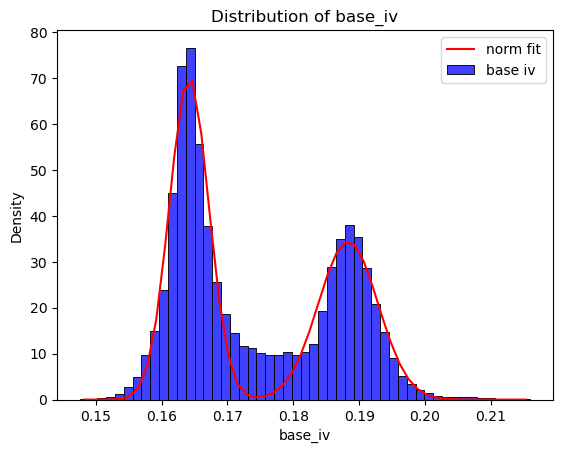

第一个正态分布: 均值=0.16416659899193645, 标准差=0.002987233393805882, 振幅=0.525469046799222
第二个正态分布: 均值=0.18833222009797246, 标准差=0.004537096101941422, 振幅=0.39143885525988975


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# 假设 df 已经被加载
# df = pd.read_csv('your_data.csv')  # 根据实际情况加载数据

# 绘制原始数据的直方图
sns.histplot(df['base_iv'], kde=False, color='blue', label='base iv', stat="density")
plt.xlabel('base_iv')
plt.ylabel('Density')
plt.title('Distribution of base_iv')

# 定义一个函数来拟合两个正态分布的和
def two_gaussian(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2)

# 计算数据的均值和标准差
mean = df['base_iv'].mean()
std = df['base_iv'].std()

# 初始猜测参数
# 第一个正态分布的均值可以设为数据的均值，第二个正态分布的均值可以设为数据的均值加上/减去某个值
initial_guess = [mean - std / 2, std / 2, 0.5, mean + std / 2, std * 2, 0.5]

# 使用 np.histogram 计算直方图
y_data, bin_edges = np.histogram(df['base_iv'], bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# 使用 interp1d 进行插值以生成平滑的曲线
f = interp1d(bin_centers, y_data, kind='cubic')
y_data_smooth = f(bin_centers)

# 使用 curve_fit 来拟合两个正态分布的和
popt, _ = curve_fit(two_gaussian, bin_centers, y_data_smooth, p0=initial_guess)


# 绘制拟合曲线
plt.plot(bin_centers, two_gaussian(bin_centers, *popt), 'r-', label='norm fit')


plt.legend()
plt.show()

# 输出拟合的参数
print(f"第一个正态分布: 均值={popt[0]}, 标准差={popt[1]}, 振幅={popt[2]}")
print(f"第二个正态分布: 均值={popt[3]}, 标准差={popt[4]}, 振幅={popt[5]}")


In [32]:
from sklearn.mixture import GaussianMixture
import numpy as np

# 数据准备（reshape 为 GMM 所需格式）
X = df['base_iv'].dropna().values.reshape(-1, 1)

# 用 2 个分布拟合
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X)

# 预测每个时刻的 regime（状态标签）
regimes = gmm.predict(X)

# 将 regime 标签加入原始 df（需要对齐索引）
df = df.loc[df['base_iv'].notnull()].copy()
df['base_iv_regime'] = regimes

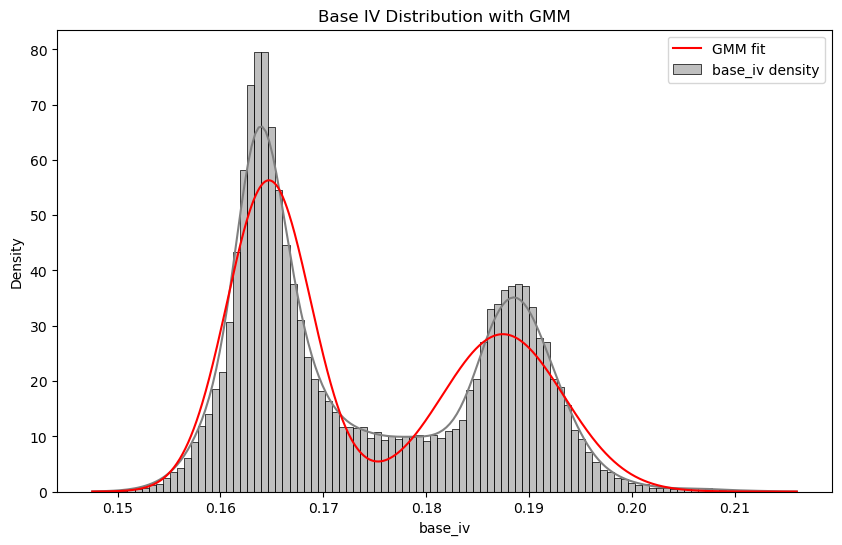

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['base_iv'], bins=100, kde=True, color='gray', stat='density', label='base_iv density')

# 画出 GMM 拟合的两个正态分布
x = np.linspace(df['base_iv'].min(), df['base_iv'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
plt.plot(x, pdf, label='GMM fit', color='red')

plt.title("Base IV Distribution with GMM")
plt.legend()
plt.show()

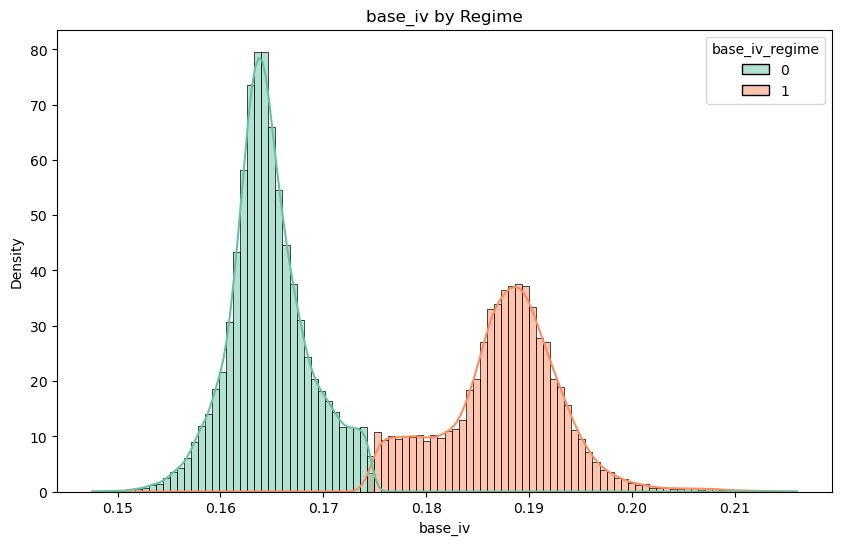

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='base_iv', hue='base_iv_regime', bins=100, stat='density', kde=True, palette='Set2')
plt.title("base_iv by Regime")
plt.show()

In [40]:
df['delta_iv_9500'] = df['fitted_iv_9500'] - df['iv_9500']
df['delta_iv_9750'] = df['fitted_iv_9750'] - df['iv_9750']
df['delta_iv_10000'] = df['fitted_iv_10000'] - df['iv_10000']
df['delta_iv_10250'] = df['fitted_iv_10250'] - df['iv_10250']
df['delta_iv_10500'] = df['fitted_iv_10500'] - df['iv_10500']

In [65]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]

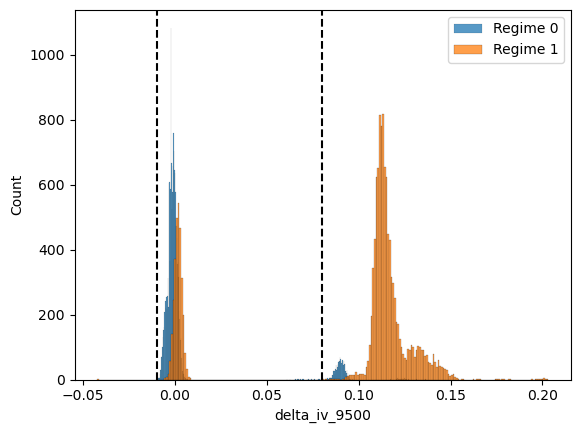

In [72]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9500'], label = 'Regime 1')
plt.axvline(x=0.08, color='black', linestyle='--')
plt.axvline(x=-0.01, color='black', linestyle='--')

plt.legend()

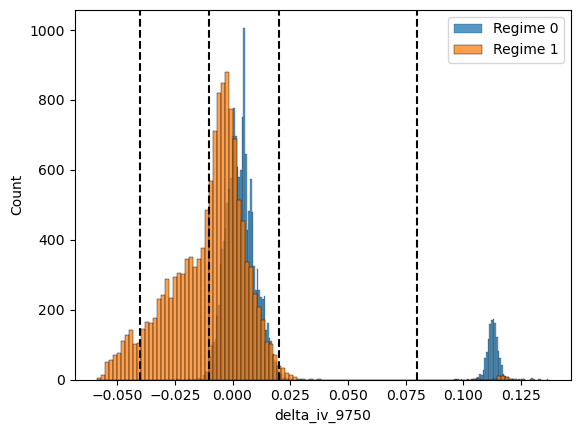

In [77]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_9750'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_9750'], label = 'Regime 1')
plt.axvline(x=0.08, color='black', linestyle='--')
plt.axvline(x=-0.01, color='black', linestyle='--')
plt.axvline(x=0.02, color='black', linestyle='--')
plt.axvline(x=-0.04, color='black', linestyle='--')
plt.legend()

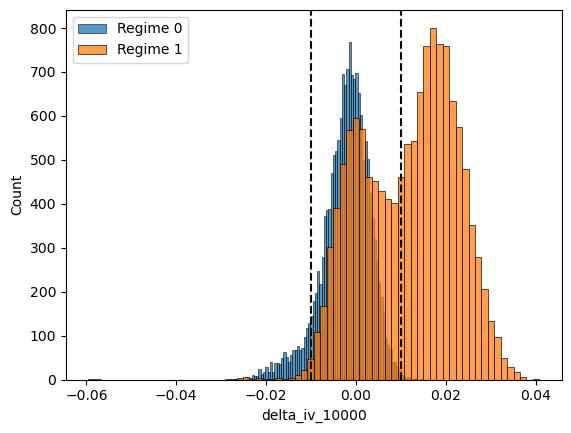

In [79]:
sns.histplot(df_regime0['delta_iv_10000'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10000'], label = 'Regime 1')
plt.axvline(x=0.01, color='black', linestyle='--')
plt.axvline(x=-0.01, color='black', linestyle='--')

plt.legend()

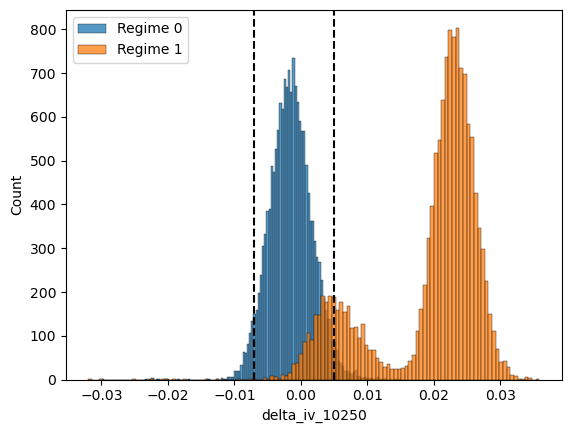

In [81]:
sns.histplot(df_regime0['delta_iv_10250'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10250'], label = 'Regime 1')
plt.axvline(x = 0.005, color = 'black', linestyle = '--')
plt.axvline(x = -0.007, color = 'black', linestyle = '--')

plt.legend()

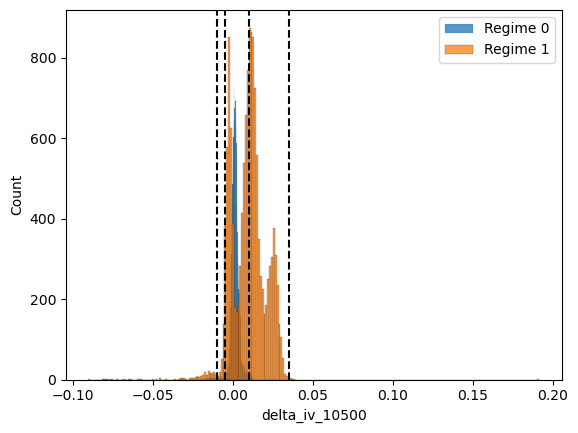

In [87]:
import seaborn as sns
sns.histplot(df_regime0['delta_iv_10500'], label = 'Regime 0')
sns.histplot(df_regime1['delta_iv_10500'], label = 'Regime 1')
plt.axvline(x=0.01, color='black', linestyle='--')
plt.axvline(x=-0.01, color='black', linestyle='--')
plt.axvline(x=0.035, color='black', linestyle='--')
plt.axvline(x=-0.005, color='black', linestyle='--')


plt.legend()

In [57]:
df_regime0[df_regime0['base_iv_regime'] ==0]['base_iv'].describe()

count    23052.000000
mean         0.164671
std          0.003873
min          0.147533
25%          0.162400
50%          0.164294
75%          0.166788
max          0.174684
Name: base_iv, dtype: float64

In [58]:
df_regime1[df_regime1['base_iv_regime'] ==1]['base_iv'].describe()

count    16948.000000
mean         0.187518
std          0.005727
min          0.174686
25%          0.184463
50%          0.187990
75%          0.190972
max          0.216025
Name: base_iv, dtype: float64

<Axes: xlabel='VOLCANIC_ROCK', ylabel='Count'>

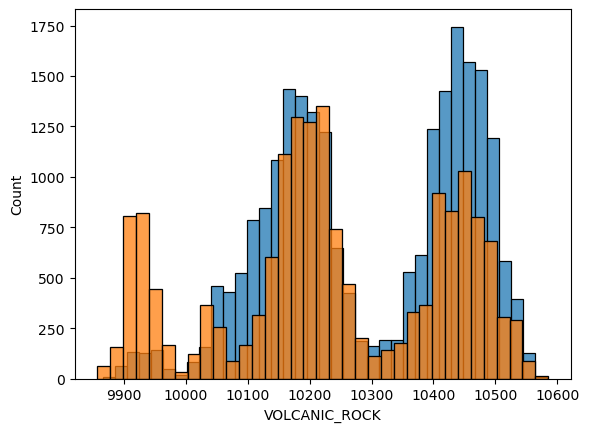

In [61]:
sns.histplot(df_regime0['VOLCANIC_ROCK'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK'], label = 'Regime 1')

In [68]:
df['VOLCANIC_ROCK_diff'] = df['VOLCANIC_ROCK'] - df['VOLCANIC_ROCK'].shift(1)
df['VOLCANIC_ROCK_vol20'] = df['VOLCANIC_ROCK_diff'].rolling(window=20).std()
df.dropna(inplace = True)

In [69]:
df_regime0 = df[df['base_iv_regime'] == 0]
df_regime1 = df[df['base_iv_regime'] == 1]

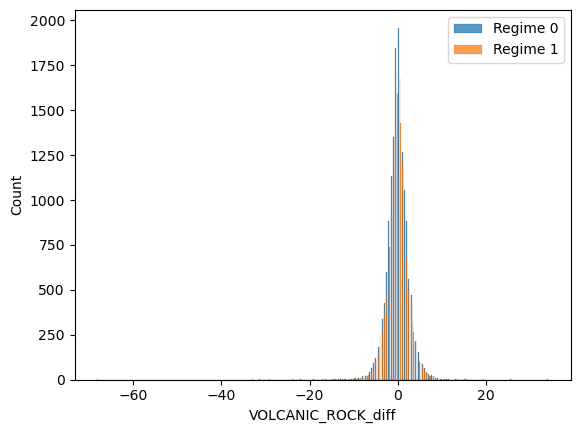

In [67]:
sns.histplot(df_regime0['VOLCANIC_ROCK_diff'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK_diff'], label = 'Regime 1')
plt.legend()

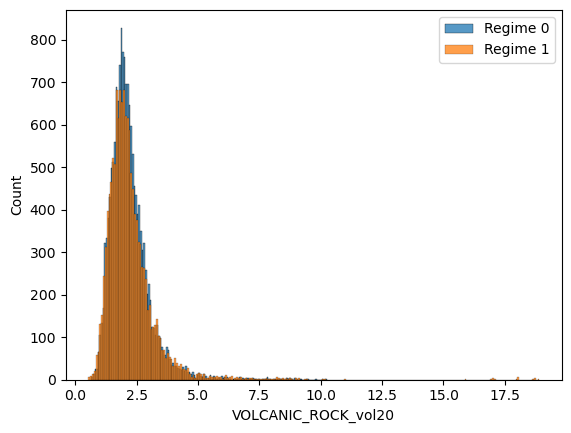

In [70]:
sns.histplot(df_regime0['VOLCANIC_ROCK_vol20'], label = 'Regime 0')
sns.histplot(df_regime1['VOLCANIC_ROCK_vol20'], label = 'Regime 1')
plt.legend()